<a href="https://colab.research.google.com/github/glukonatic/III/blob/master/Copy_of_III_PRO_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание к занятию №2 "Полносвязные сети, обучающая и тестовая выборки"
## студента Университета искусственного интеллекта
## Наговицына Антона Михайловича
### Поток PRO НС - апрель 2020 (основной тариф).
<img src="https://proza.ru/photos/glukonatic.jpg" alt="Фото Антон Наговицын" width="10%">

# Light

Создайте модель для распознавания рукописных цифр из набора MNIST (можно воспользоваться
ноутбуком 1-го занятия) и проведите ряд тестов:

1. Запустите сеть с различными размерами обучающей и проверочной выборок:
  *   Обучающая выборка 50.000 примеров
  *   Обучающая выборка 10.000 примеров
  *   Обучающая выборка 500 примеров

2. Создайте еще два варианта сети и сравните значения точности на проверочной выборке (на последней эпохе) и на тестовой выборке. Сделайте сравнительную таблицу.

3. Создайте сеть следующей архитектуры:
  *   Dense слоя
  *   Dropout слоя
  *   BatchNormalization слоя

Напишите свои выводы по результатам проведенных тестов.

In [0]:
#@title 0. Импорт библиотек и определение глобальных переменных и функций, необходимых для экспериментов для задания Light

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
import numpy as np
import pylab as pl
import pandas as pd
from collections import defaultdict
from random import randint, choice
import math
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
%matplotlib inline


#@markdown Для построения модели можно указать размер обучающей выборки (defTrain). Для обучения - количество эпох defEpochs, параметром defVerbose можно установить отображение процесса обучения

defEpochs = 5 #@param {type:"number"}
defTrain = 50000 #@param {type:"number"}
defVerbose = "1" #@param [0, 1] {allow-input: false}
defNeyronsInput =  320
defHiddenLayers = 1
defNeyronsHidden = 128
defBatchSize = 128
defActivation = 'relu'

# Исходные данные датасета
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data()

# Приведение данных датасета к необходимому виду
x_train = x_train_org.reshape(60000, 784)
x_test = x_test_org.reshape(10000, 784)
x_train = x_train.astype('float32')
x_train = x_train / 255
x_test = x_test.astype('float32')
x_test = x_test / 255
y_train = utils.to_categorical(y_train_org, 10)
y_test = utils.to_categorical(y_test_org, 10)




class Model:
  '''
    Класс моделей
  '''
  
  def __init__(self, numOfNeyronsInput=defNeyronsInput, 
               numOfHiddenLayers=defHiddenLayers, 
               numOfNeyronsHidden=defNeyronsHidden, 
               activation=defActivation,
               listOfLayers=[]):
    '''
      Инициализация. Создается модель с заданными параметрами. Создаются элементы класса
    '''
    self.history = defaultdict()
    self.inputNeyrons = numOfNeyronsInput
    self.hiddenLayers = numOfHiddenLayers
    self.hiddenNeyrons = numOfNeyronsHidden
    self.activation = activation
    self.model = Sequential()
    self.model.add(Dense(self.inputNeyrons, input_dim=784, activation=self.activation))
    for i in range(self.hiddenLayers):    
      self.model.add(Dense(self.hiddenNeyrons, activation=self.activation))
    for layerType in listOfLayers:
      if layerType == 'BatchNormalization':
        self.model.add(BatchNormalization())
      if layerType == 'Dropout':
        self.model.add(Dropout(0.1))
      if layerType == 'Dense':
        self.model.add(Dense(30, activation='relu'))   
    self.model.add(Dense(10, activation="softmax"))

  def compileModel(self, optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']):
    '''
      Компиляция
    '''
    self.model.compile(optimizer, loss,  metrics)


  def fitModel(self, x_train=x_train, y_train=y_train, n_train=defTrain, 
               batchSize=defBatchSize, epochsNum=defEpochs, verboseBit=defVerbose):
    '''
      Обучение с указанными параметрами
    '''
    self.n_train = n_train
    self.batchSize = batchSize
    self.epochs = epochsNum
    self.history = self.model.fit(x_train[:self.n_train], 
                                  y_train[:self.n_train], 
                                  batch_size=self.batchSize, 
                                  epochs=self.epochs, 
                                  verbose=int(verboseBit), 
                                  validation_data=(x_train[self.n_train:], 
                                                   y_train[self.n_train:]))
  
  def scoreModel(self):
    '''
      Проверка на тестовых данных
    '''
    self.score = self.model.evaluate(x_test, y_test)




# Функция, рисующая графики на основании полученных данных в экспериментах
def runPlot(listOfModels,labels=[],mainLabel=['Графики']):
  '''
    Функция runPlot, отрисовывающая графики по полученным в экспериментах данным
    На вход принимает значения:
    paramDict - словарь полученных в результате экспериментов данных
    experimentName - определяет, какой эксперимент был проведён
    Функция ничего не возвращает
  '''
  # Инициализируем графики, их у нас всегда по два - для точности и для потерь
  f, ax = plt.subplots(2, 2, figsize = (25,10))
  f.suptitle(mainLabel)

  for model in listOfModels:
#    labels.append('in: ' + str(model.inputNeyrons) + \
#                  '  hidL: ' + str(model.hiddenLayers) + \
#                  '  hidN: ' + str(model.hiddenNeyrons) + \
#                  '  act: ' + model.activation + \
#                  '  n_train: ' + str(model.n_train))
    ax[0][0].plot(model.history.history['accuracy'])
    ax[0][1].plot(model.history.history['val_accuracy'])
    ax[1][0].plot(model.history.history['loss'])
    ax[1][1].plot(model.history.history['val_loss'])

  ax[0][0].set_title('Точность моделей на обучающей выборке')
  ax[0][0].set_ylabel('Точность')
  ax[0][0].set_xlabel('Эпохи')
  ax[0][0].grid(color='g', linestyle=':', linewidth=1)
  ax[0][0].legend(labels, loc='lower right')
  ax[1][0].set_title('Потери моделей на обучающей выборке')
  ax[1][0].set_ylabel('Потери')
  ax[1][0].set_xlabel('Эпохи')
  ax[1][0].grid(color='g', linestyle=':', linewidth=1)
  ax[1][0].legend(labels, loc='upper right')
  ax[0][1].set_title('Точность моделей на проверочной выборке')
  ax[0][1].set_ylabel('Точность')
  ax[0][1].set_xlabel('Эпохи')
  ax[0][1].grid(color='g', linestyle=':', linewidth=1)
  ax[0][1].legend(labels, loc='lower right')
  ax[1][1].set_title('Потери моделей на проверочной выборке')
  ax[1][1].set_ylabel('Потери')
  ax[1][1].set_xlabel('Эпохи')
  ax[1][1].grid(color='g', linestyle=':', linewidth=1)
  ax[1][1].legend(labels, loc='upper right')

Epoch 1/5
391/391 [==============================] - 3s 6ms/step - loss: 0.2877 - accuracy: 0.9172 - val_loss: 0.1330 - val_accuracy: 0.9624
Epoch 2/5
391/391 [==============================] - 2s 6ms/step - loss: 0.1082 - accuracy: 0.9677 - val_loss: 0.0966 - val_accuracy: 0.9704
Epoch 3/5
391/391 [==============================] - 2s 6ms/step - loss: 0.0700 - accuracy: 0.9784 - val_loss: 0.0852 - val_accuracy: 0.9742
Epoch 4/5
391/391 [==============================] - 2s 6ms/step - loss: 0.0474 - accuracy: 0.9853 - val_loss: 0.0864 - val_accuracy: 0.9757
Epoch 5/5
391/391 [==============================] - 2s 6ms/step - loss: 0.0359 - accuracy: 0.9884 - val_loss: 0.0818 - val_accuracy: 0.9754
Epoch 1/5
79/79 [==============================] - 2s 20ms/step - loss: 0.6052 - accuracy: 0.8365 - val_loss: 0.3106 - val_accuracy: 0.9109
Epoch 2/5
79/79 [==============================] - 1s 18ms/step - loss: 0.2201 - accuracy: 0.9381 - val_loss: 0.2529 - val_accuracy: 0.9234
Epoch 3/5
79/79

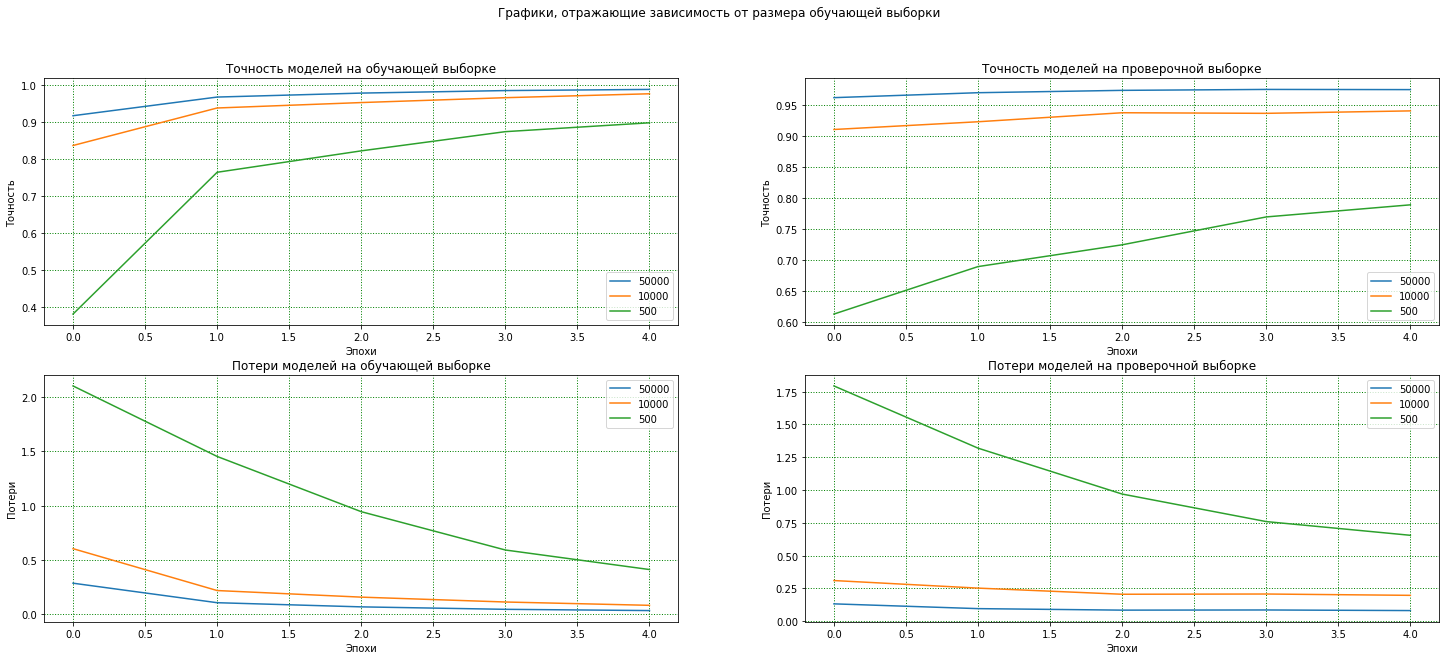

In [0]:
#@title 1. Запустите сеть с различными размерами обучающей и проверочной выборок (50000 / 10000 / 500 примеров в обучающей выборке)

#@markdown Для построения модели можно указать размер обучающей выборки (создадим три модели)

n_train1 = 50000 #@param {type:"number"}
n_train2 = 10000 #@param {type:"number"}
n_train3 = 500 #@param {type:"number"}

model_50k = Model()
model_10k = Model()
model_500 = Model()

model_50k.compileModel()
model_10k.compileModel()
model_500.compileModel()

model_50k.fitModel(n_train=n_train1)
model_10k.fitModel(n_train=n_train2)
model_500.fitModel(n_train=n_train3)

labels = [n_train1,n_train2,n_train3]
mainLabel = 'Графики, отражающие зависимость от размера обучающей выборки'
runPlot([model_50k,model_10k,model_500],labels,mainLabel)

In [0]:
#@title 2. Создайте еще два варианта сети и сравните значения точности на проверочной выборке (на последней эпохе) и на тестовой выборке. Сделайте сравнительную таблицу.

#@markdown Инициализация начала эксперимента 2, а так же сброс эксперимента 2 при уже имеющихся опытах.

models = []
labels = []

In [0]:
#@markdown Для построения кастомных моделей можно указать разные параметры. Каждый запуск этой ячейки дает +1 модель. 

random_or_manual = "\u0418\u0437 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u044B\u0445 \u043D\u0438\u0436\u0435 \u043F\u0430\u0440\u0430\u043C\u0435\u0442\u0440\u043E\u0432"  #@param ['Случайно', 'Из указанных ниже параметров']
neyronsInput =   800#@param {type:"number"}
hiddenLayers = 0 #@param {type:"number"}
neyronsHidden =  8#@param {type:"number"}
activation = 'hard_sigmoid'  #@param ['relu', 'linear', 'tanh', 'elu', 'selu', 'sigmoid', 'hard_sigmoid', 'exponential']

if random_or_manual == "Случайно":
  neyronsInput = choice([128,256,512])
  neyronsHidden = choice([64,128,256])
  hiddenLayers = choice([1,2])
  activation = choice(['relu', 'linear', 'tanh'])
  
if hiddenLayers > 0: 
  labels.append('Вход,нейронов:'+str(neyronsInput)+' внутр.слой,нейронов:'+str(neyronsHidden)+' внутр.слоёв:'+str(hiddenLayers)+' ф.актив:'+activation)
elif hiddenLayers == 0: 
  labels.append('Вход,нейронов:'+str(neyronsInput)+' внутр.слоёв:'+str(hiddenLayers)+' ф.актив:'+activation)
models.append(Model(numOfNeyronsInput=neyronsInput,numOfHiddenLayers=hiddenLayers,
                numOfNeyronsHidden=neyronsHidden,activation=activation))

Epoch 1/5
391/391 [==============================] - 5s 12ms/step - loss: 0.2713 - accuracy: 0.9219 - val_loss: 0.1384 - val_accuracy: 0.9612
Epoch 2/5
391/391 [==============================] - 5s 12ms/step - loss: 0.1081 - accuracy: 0.9682 - val_loss: 0.0904 - val_accuracy: 0.9738
Epoch 3/5
391/391 [==============================] - 4s 11ms/step - loss: 0.0683 - accuracy: 0.9796 - val_loss: 0.0845 - val_accuracy: 0.9742
Epoch 4/5
391/391 [==============================] - 4s 11ms/step - loss: 0.0463 - accuracy: 0.9872 - val_loss: 0.0739 - val_accuracy: 0.9794
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0646 - accuracy: 0.9805
Epoch 1/5
391/391 [==============================] - 4s 11ms/step - loss: 0.3756 - accuracy: 0.8899 - val_loss: 0.3083 - val_accuracy: 0.9154
Epoch 2/5
391/391 [==============================] - 4s 11ms/step - loss: 0.3118 - accuracy: 0.9113 - val_loss: 0.2890 - val_accuracy: 0.9178
Epoch 3/5
391/391 [==============================

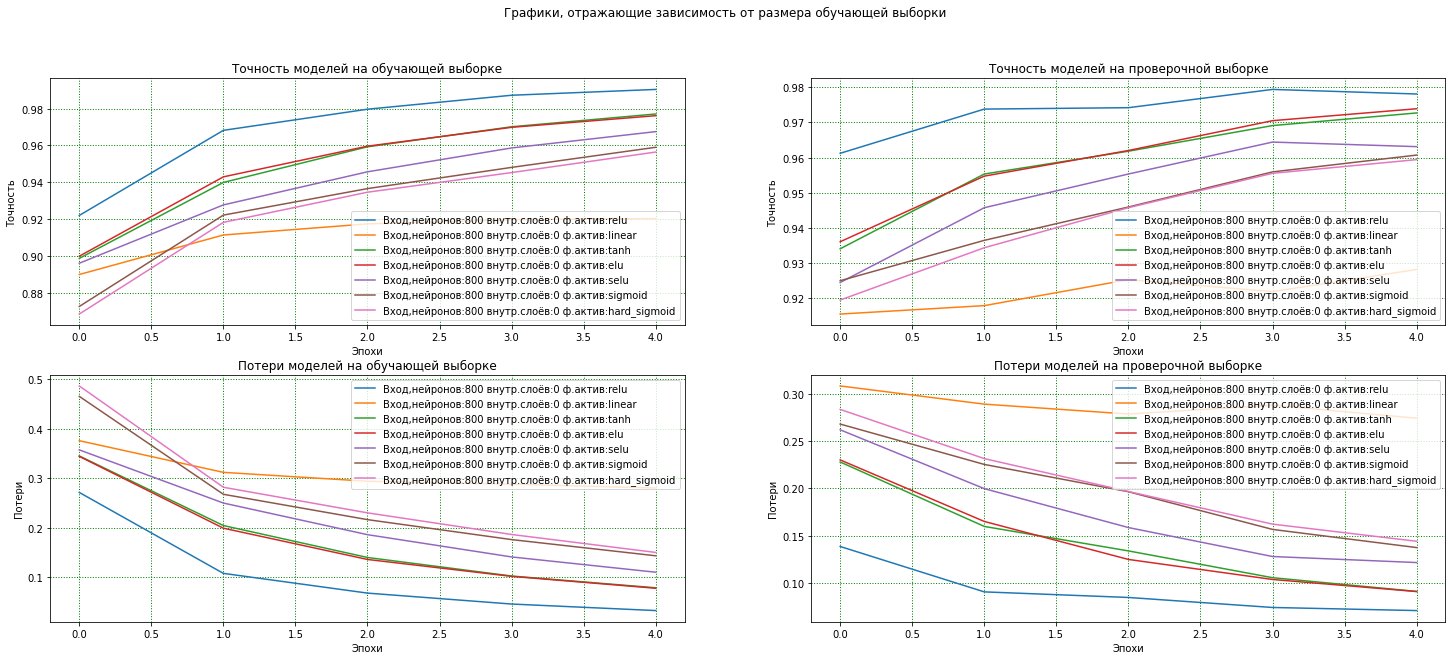

In [0]:
#@markdown Компиляция и обучение созданных моделей, построение графиков

for model in models:
  model.compileModel()
  model.fitModel()
  model.scoreModel()

mainLabel = 'Графики, отражающие зависимость от размера обучающей выборки'
runPlot(models,labels,mainLabel)

In [0]:
#@markdown Прогон тестовой порции сета данных, сведение итогов в таблицу

indexes = ['Нейронов на входе','Скрытых слоёв','Нейронов в скр.сл.','Функция активации',
           'Потери трен.набора','Потери тест.набора','Точность трен.набора','Точность тест.набора']

df = pd.DataFrame(index=indexes)

for i, model in enumerate(models):
  df[i+1] = [model.inputNeyrons,model.hiddenLayers,model.hiddenNeyrons,model.activation,
             model.history.history['val_loss'][-1],model.score[0],
             model.history.history['val_accuracy'][-1],model.score[1]]

print('Выведем сводную таблицу, полученную в результате проведения экспериментов. Строки - эксперименты')
df.T

Выведем сводную таблицу, полученную в результате проведения экспериментов. Строки - эксперименты


,Нейронов на входе,Скрытых слоёв,Нейронов в скр.сл.,Функция активации,Потери трен.набора,Потери тест.набора,Точность трен.набора,Точность тест.набора
1,800,0,8,relu,0.0758122,0.0696389,0.9771,0.9788
2,800,1,8,relu,0.0897254,0.0772062,0.9758,0.9754
3,800,1,100,relu,0.0902011,0.0845224,0.9735,0.9748
4,800,1,300,relu,0.0774998,0.0689815,0.9787,0.9806
5,800,1,800,relu,0.0699609,0.0752409,0.9812,0.9802
6,800,1,1400,relu,0.0882617,0.0798421,0.977,0.9791


Epoch 1/5
391/391 [==============================] - 3s 8ms/step - loss: 0.3048 - accuracy: 0.9097 - val_loss: 0.1410 - val_accuracy: 0.9593
Epoch 2/5
391/391 [==============================] - 3s 7ms/step - loss: 0.1101 - accuracy: 0.9672 - val_loss: 0.0969 - val_accuracy: 0.9710
Epoch 3/5
391/391 [==============================] - 3s 8ms/step - loss: 0.0734 - accuracy: 0.9782 - val_loss: 0.0916 - val_accuracy: 0.9712
Epoch 4/5
391/391 [==============================] - 3s 8ms/step - loss: 0.0539 - accuracy: 0.9832 - val_loss: 0.0981 - val_accuracy: 0.9720
Epoch 5/5
391/391 [==============================] - 3s 8ms/step - loss: 0.0413 - accuracy: 0.9867 - val_loss: 0.0911 - val_accuracy: 0.9731
Epoch 1/5
391/391 [==============================] - 3s 7ms/step - loss: 0.2870 - accuracy: 0.9168 - val_loss: 0.1240 - val_accuracy: 0.9634
Epoch 2/5
391/391 [==============================] - 3s 7ms/step - loss: 0.1053 - accuracy: 0.9683 - val_loss: 0.0989 - val_accuracy: 0.9706
Epoch 3/5
391

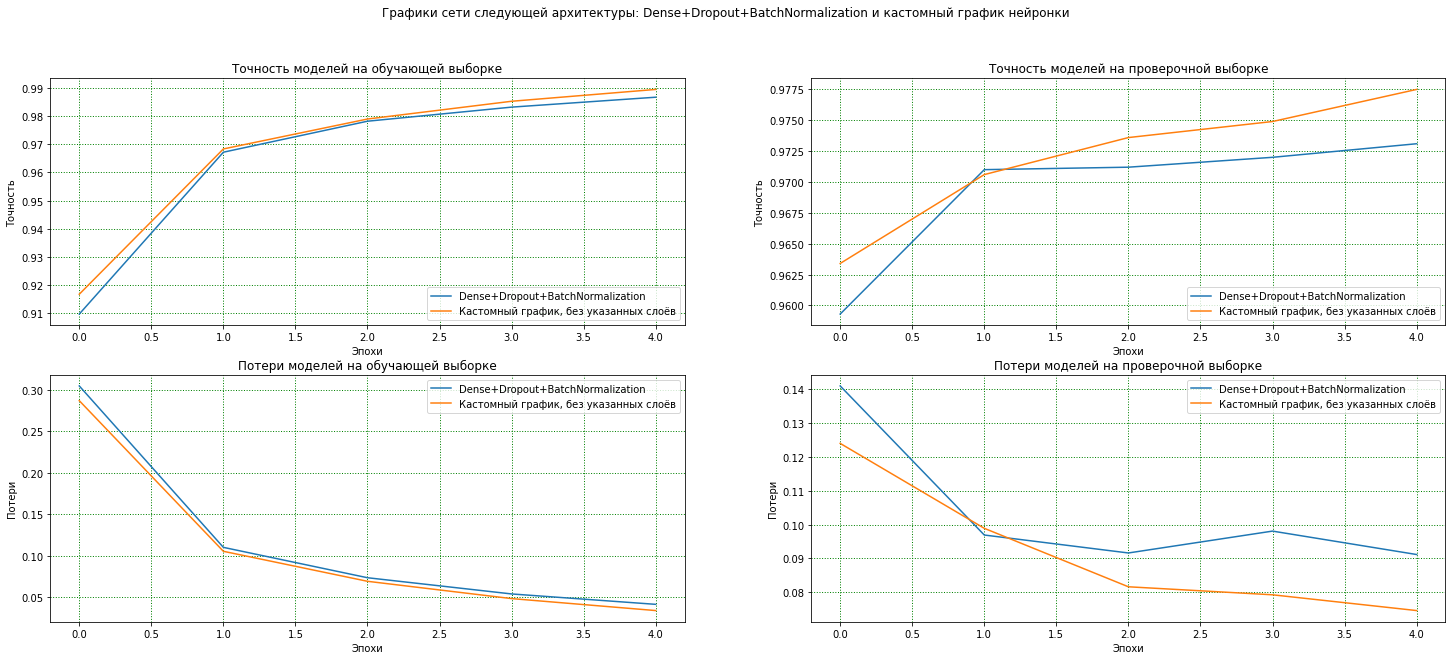

In [0]:
#@title Создайте сеть следующей архитектуры: Dense+Dropout+BatchNormalization

modelDDB = Model(listOfLayers=['BatchNormalization','Dropout','Dense'])
modelCustom = Model()

modelDDB.compileModel()
modelCustom.compileModel()

modelDDB.fitModel()
modelCustom.fitModel()

mainLabel = 'Графики сети следующей архитектуры: Dense+Dropout+BatchNormalization и кастомный график нейронки'
labels = ['Dense+Dropout+BatchNormalization','Кастомный график, без указанных слоёв']
runPlot([modelDDB,modelCustom],labels=labels,mainLabel=mainLabel)

Выводы:
1. Размер обучающей выборки напрямую влияет на качество обучения сети
2. Если сравнивать модели с одним внутренним слоем, то модель с 128 входными нейронами на первом слое и 8 нейронами на скрытом работает лучше, чем модель с 8 нейронами на первом слое и 128 на скрытом. Проводились несколько опытов. Но это только из-за того, что на 1 слое мало нейронов. Дальнейшие опыты показали, что чаще всего большее влияние имеет увеличение числа нейронов на скрытом слое. На первом слое можно сказать, должно быть какое-то оптимальное значение нейронов, достаточное для приятной функциональности нейронки.
3. Если сравнивать работу сетей без скрытого слоя, то можно сделать вывод, что при количестве нейронов равным 8 на первом слое модель уже даёт хорошую точность при прогоне тестового набора после обучения. Но так же надо отметить, что 800 нейронов на первом слое дают более высокую точность. При этом при повышении числа нейронов на входе более 800 нейронов, точность не увеличивается и колеблется около значения точности модели с 800 нейронами в первом слое.
4. При сравнении точности модели, не содержащей скрытого слоя, и содержащей на первом слое 800 нейронов, с работой моделей с разным количеством нейронов на скрытом слое, то можно сделать вывод, что скрытый слой вообще не нужен для решения этой задачи.
5. Введение в сеть слоёв Dropout и BatchNormalization не показывает своей необходимости и эффективность модели не повышают.

# Pro. Вариант 1

Повысьте точность модели по обнаружению мин до 90% на тестовой выборке. Можно использовать различные варианты слоев Dropout и BatchNormalization. Можно менять количество примеров в обучающей и проверочной выборках, но нельзя менять количество примеров в тестовой.


Примечание: выполняя эксперименты, на каждом шагу определялись те или иные наиболее подходящие для обучения параметры сети, и эти параметры устанавливались по умолчанию для всех шагов эксперимента, где указаны статичные параметры.

In [0]:
#@title Импорт библиотек

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from collections import defaultdict
from random import randint, choice, seed
from google.colab import files
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#@markdown Для построения модели можно указать часть сета, выделяемую под тесты defTestSize. Для обучения - параметром defVerbose можно установить отображение процесса обучения, в defEpochs можно определить число эпох обучения, коэффициент для слоя Dropout (defDropOut) и число нейронов на первом слое нейронной сети defFLNeyrons. Эти параметры используются по умолчанию а двльнейшем, если иного не определено на очередном шаге эксперимента. Напоследок, добавлена опция выбора преждевременной остановки проведения обучения при достижении определенной точности модели (defEarlyStop). Здесь же задаются глобальные переменные.

# Инициализируем переменные для последующих экспериментов

defTestSize = 0.2   #@param {type: "slider", min: 0.05, max: 0.5, step: 0.05}
defVerbose = "0"    #@param [0, 1] {allow-input: false}
defEpochs = 100     #@param {type:"number", min: 5, max: 100}
defDropOut=0.3      #@param {type: "slider", min: 0.1, max: 0.5, step: 0.1}
defFLNeyrons=200    #@param {type:"number", min: 8, max: 2000}
defEarlyStop = "0"  #@param [0, 1] {allow-input: false}


# Переменная для реализации остановки обучения при достижении указанных параметров
earlyStopFit = EarlyStopping(
    monitor = 'val_loss', # Отслеживаемый параметр (метрика).
    min_delta = 0, # минимальное изменение метрики, 
                                # которое можно считать за признак остановки, 
                                # то есть если абсолютное значение изменения больше этого параметра, 
                                # то происходит остановка
    patience = 2, # число эпох, пройденных при обучении, 
                                # на протяжении которых дельта не менялась. 
                                # При превышении этого числа - остановка
    verbose = int(defVerbose), # режим детализации
    mode = 'min', # одно из значений {auto, min, max}. 
                                # Если указано "min", обучение будет остановлено, 
                                # когда отслеживаемая метрика прекратит уменьшаться; 
                                # если указано "max", то обучение остановится 
                                # при прекращении увеличения отслеживаемой метрики; 
                                # при "auto" режиме обучение автоматически прекратится
                                # при прекращении изменения метрики.
    baseline = None, # опорное значение метрики. 
                                # Обучение будет остановлено, 
                                # если модель не покажет улучшение выше, чем этот параметр
    restore_best_weights = True # Следует ли восстанавливать веса модели, 
                                # вычисленные при достижении наилучшего показания метрики. 
                                # Если False, то модель будет иметь значения весов, 
                                # вычисленных на последнем шаге обучения
)


In [0]:
#@title Объявление класса NN для экспериментов с нейронными сетями по заданию Pro. Вариант 1

class NN:

    '''
      Класс моделей нейронки
    '''

    def __init__(self):
      '''
       Инициализация последовательной модели нейронной сети
      '''
      self.history = defaultdict()  # словарь для сохранения истории обучения
      self.model = Sequential()     # инициализация последовательной модели нейронки

    def createModel(self,
                    listOfLayers=['BatchNormalization','Dense'], # список скрытых слоёв
                    firstLayerNeyrons=defFLNeyrons,         # количество нейронов на первом слое
                    koeffDropOut=defDropOut                 # коэффициент для слоя Dropout
                    ):
      '''
        Конструктор. Создается модель с заданными параметрами. Создаются элементы класса
      '''
      self.model.add(Dense(firstLayerNeyrons, activation='relu', input_shape=(60, )))
      for layerType in listOfLayers:
        if layerType == 'BatchNormalization':
          self.model.add(BatchNormalization())
        if layerType == 'Dropout':
          self.model.add(Dropout(koeffDropOut))
        if layerType == 'Dense':
          self.model.add(Dense(30, activation='relu'))
      self.model.add(Dense(1, activation='sigmoid'))
      self.model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])


    def fitModel(self,
                 x,               # сет обучения x_train
                 y,               # сет валидации y_train
                 v=0.2,           # коэффициент-разделитель сета обучения / сета валидации
                 batchSize=8,     # размер пачки единовременного пакета обучения
                 epochs=defEpochs,            # количество эпох для обучения
                 verboseBit=int(defVerbose),  # бит вывода процесса обучения
                 epochsDrop=10,   # параметр для настройки скорости обучения
                 drop=0.5,
                 earlyStop=defEarlyStop):       # параметр для настройки скорости обучения
      '''
        Обучение модели с определёнными параметрами
      '''
      self.drop=drop
      self.epochs_drop = epochsDrop
      self.lrate = LearningRateScheduler(self.step_decay)
      if earlyStop == "1":
        callbackList = [self.lrate,earlyStopFit]
      elif earlyStop == "0":
        callbackList = [self.lrate]
      self.history = self.model.fit(x,y,batch_size=batchSize,epochs=epochs,validation_split=v,
                              verbose=verboseBit,callbacks=callbackList
                              )


    def scoreModel(self, x, y):
      '''
        Прогон тестового сета
      '''
      self.score = self.model.evaluate(x, y)
    

    def step_decay(self,epoch):
      '''
        Функция для расчёта изменяемого шага обучения
      '''
      initial_lrate = 0.001
      lrate = initial_lrate * math.pow(self.drop, math.floor((1+epoch)/self.epochs_drop))
      return lrate

In [0]:
#@title Инициализация функции построения графиков

# Функция, рисующая графики на основании полученных данных в экспериментах
def runPlot(listOfModels,labels=[],mainLabel='Графики'):
  '''
    Функция runPlot, отрисовывающая графики по полученным в экспериментах данным
    На вход принимает значения:
    listOfModels - список моделей класса NN
    labels - подписи к графикам (легенда)
    mainLabel - главная подпись к графикам
    Функция ничего не возвращает
  '''
  # Инициализируем графики, их у нас всегда по два - для точности и для потерь
  f, ax = plt.subplots(2, 2, figsize = (25,10))
  f.suptitle(mainLabel)

  for model in listOfModels:
    ax[0][0].plot(model.history.history['accuracy'])
    ax[0][1].plot(model.history.history['val_accuracy'])
    ax[1][0].plot(model.history.history['loss'])
    ax[1][1].plot(model.history.history['val_loss'])

  ax[0][0].set_title('Точность моделей на обучающей выборке')
  ax[0][1].set_title('Точность моделей на проверочной выборке')
  ax[1][0].set_title('Потери моделей на обучающей выборке')
  ax[1][1].set_title('Потери моделей на проверочной выборке')
  ax[0][0].grid(color='g', linestyle=':', linewidth=1)
  ax[1][0].grid(color='g', linestyle=':', linewidth=1)
  ax[0][1].grid(color='g', linestyle=':', linewidth=1)
  ax[1][1].grid(color='g', linestyle=':', linewidth=1)
  ax[0][0].legend(labels, loc='lower right')
  ax[0][1].legend(labels, loc='lower right')
  ax[1][0].legend(labels, loc='upper right')
  ax[1][1].legend(labels, loc='upper right')
  ax[0][0].set_ylabel('Точность')
  ax[0][0].set_xlabel('Эпохи')
  ax[0][1].set_ylabel('Точность')
  ax[0][1].set_xlabel('Эпохи')
  ax[1][0].set_ylabel('Потери')
  ax[1][0].set_xlabel('Эпохи')
  ax[1][1].set_ylabel('Потери')
  ax[1][1].set_xlabel('Эпохи')


In [7]:
#@title Загрузка сета мин
!rm sonar*
files.upload()
!ls # Выводим содержимое корневой папки

df = pd.read_csv("sonar.csv", header=None)
#df.head()    

dataArray = df.values
X = dataArray[:,0:60].astype(float)
Y = dataArray[:,60]
Y[Y=='R']='0'
Y[Y=='M']='1'
Y = Y.astype(int)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=defTestSize, shuffle=True)  

rm: cannot remove 'sonar*': No such file or directory


Saving sonar.csv to sonar.csv
sample_data  sonar.csv


2/2 [==============================] - 0s 3ms/step - loss: 0.2751 - accuracy: 0.8810


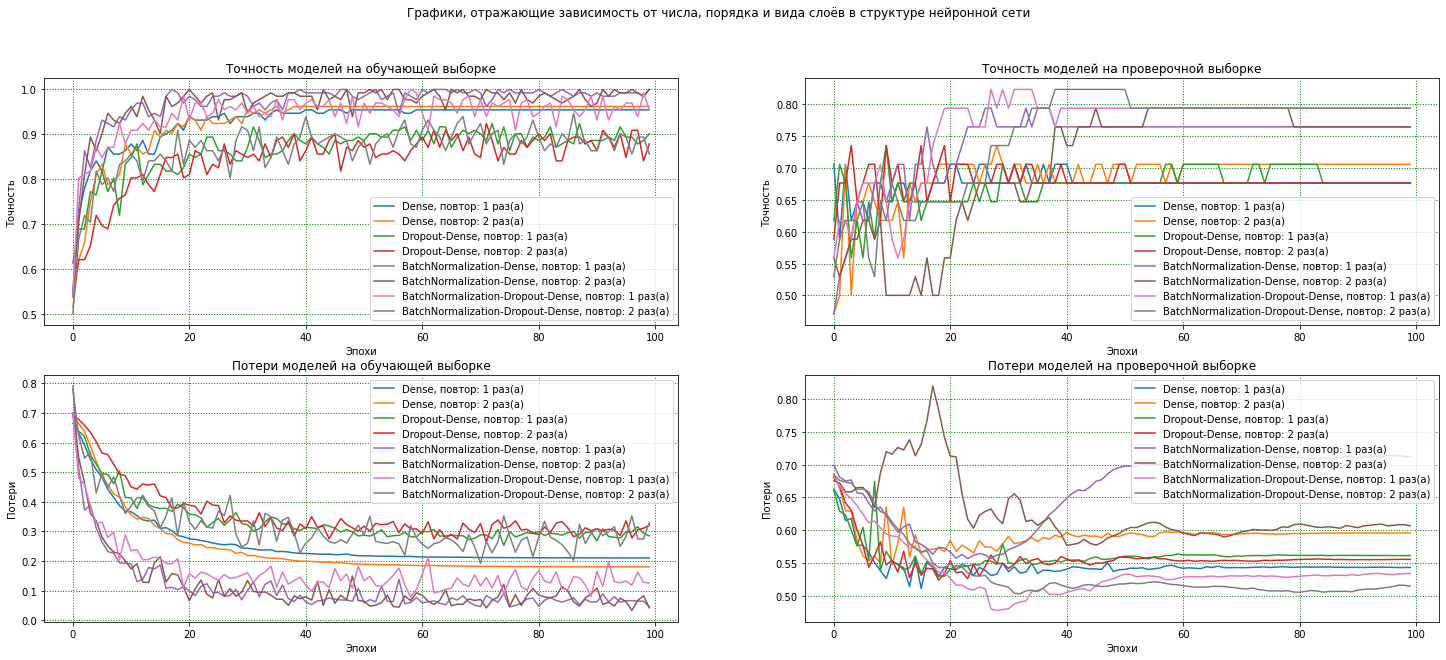

In [9]:
#@title Э1 [layers]. Ставим ряд экспериментов для выявления зависимости точности модели от числа и вида добавляемых слоёв в нейронку. Коэффициенты Dropout и validation_split берутся по умолчанию и равны, соответственно, 0.3 и 0.2.

testModels1 = []
numOfAddedLayers = 3
labels = []
layersPack = [['Dense'],
              ['Dropout','Dense'],
              ['BatchNormalization','Dense'],
              ['BatchNormalization','Dropout','Dense']]

for layerPack in layersPack:
  for repeat in range(1,numOfAddedLayers):
    M = NN()
    M.createModel(listOfLayers=layerPack*repeat)
    M.fitModel(x_train, y_train)
    M.scoreModel(x_test, y_test)
    labels.append('-'.join(layerPack)+', повтор: '+str(repeat)+' раз(а)')
    testModels1.append(M)
    if M.score[1] >= 0.90:
      print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')

mainLabel = 'Графики, отражающие зависимость от числа, порядка и вида слоёв в структуре нейронной сети'
runPlot(testModels1,labels,mainLabel)

2/2 [==============================] - 0s 1ms/step - loss: 0.2177 - accuracy: 0.9286

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.1532 - accuracy: 0.9524

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 2ms/step - loss: 0.1736 - accuracy: 0.9286

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.2531 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...



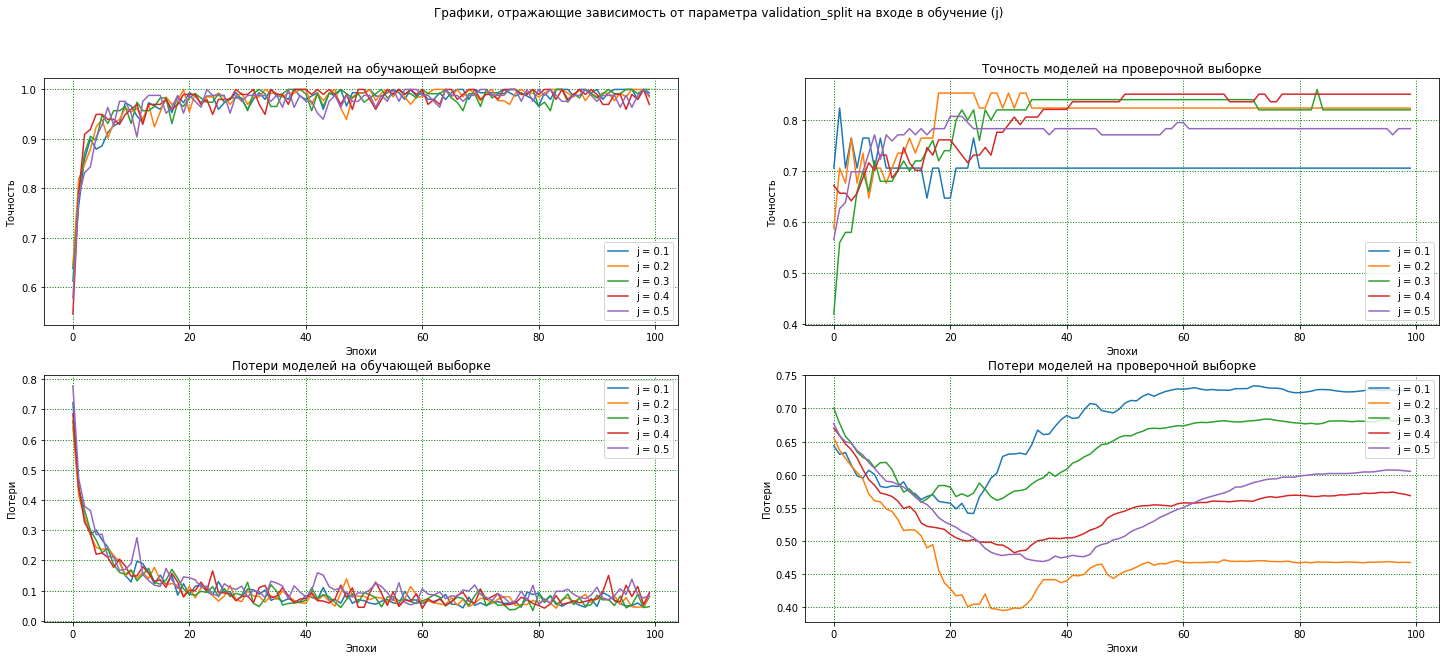

In [10]:
#@title Э2 [validation_split]. Теперь ставим другой эксперимент: определим зависимость от параметра validation_split на входе в обучение

testModels2 = []
labels = []

for j in [0.1,0.2,0.3,0.4,0.5]:
  M = NN()
  M.createModel()
  M.fitModel(x_train, y_train,v=j)
  M.scoreModel(x_test, y_test)
  labels.append('j = '+str(j))
  testModels2.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')

mainLabel = 'Графики, отражающие зависимость от параметра validation_split на входе в обучение (j)'
runPlot(testModels2,labels,mainLabel)

2/2 [==============================] - 0s 3ms/step - loss: 0.1448 - accuracy: 0.9524

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.1480 - accuracy: 0.9524

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.2480 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 1ms/step - loss: 0.2076 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...



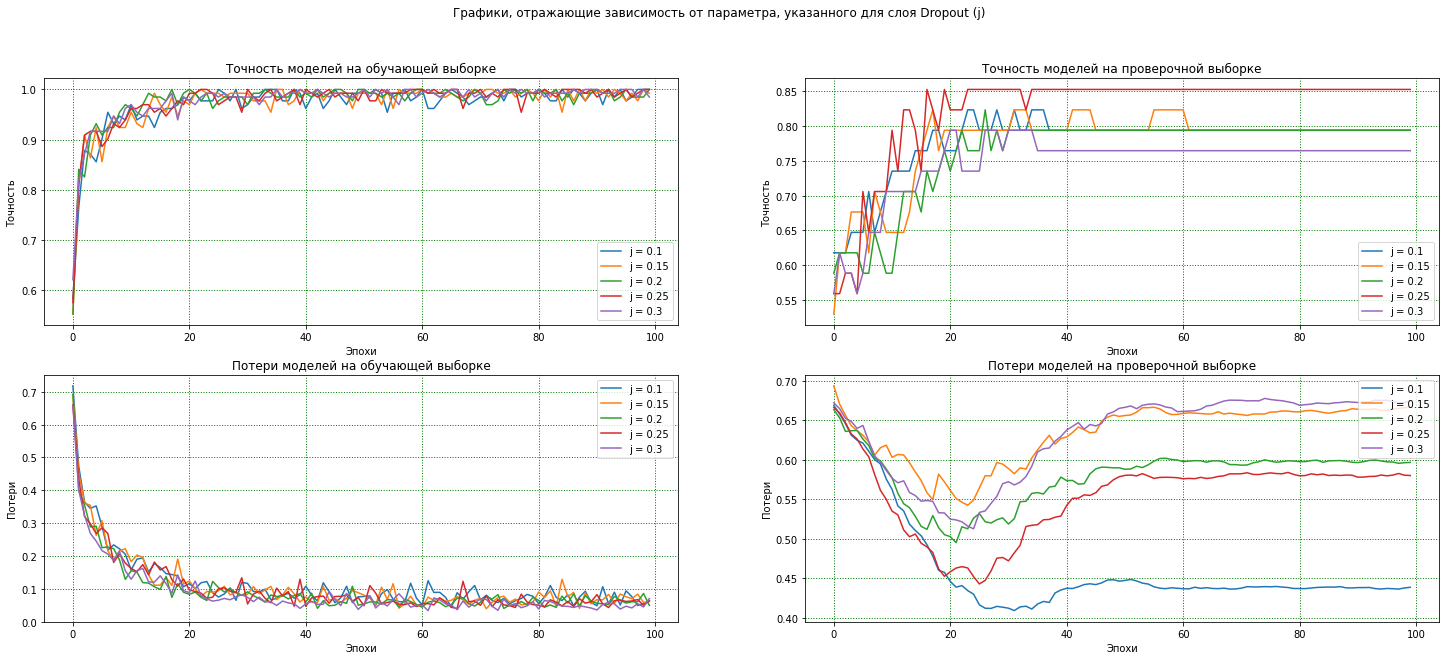

In [11]:
#@title Э3 [Dropout]. Попробуем посмотреть, как зависит точность от параметра Dropout.

testModels3 = []
labels = []

for j in [0.1,0.15,0.2,0.25,0.3]:
  M = NN()
  M.createModel(koeffDropOut=j)
  M.fitModel(x_train, y_train)
  M.scoreModel(x_test, y_test)
  labels.append('j = '+str(j))
  testModels3.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')

mainLabel = 'Графики, отражающие зависимость от параметра, указанного для слоя Dropout (j)'
runPlot(testModels3,labels,mainLabel)

2/2 [==============================] - 0s 3ms/step - loss: 0.2452 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.1421 - accuracy: 0.9524

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 2ms/step - loss: 0.1981 - accuracy: 0.9286

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.2649 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 2ms/step - loss: 0.2674 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.2052 - ac

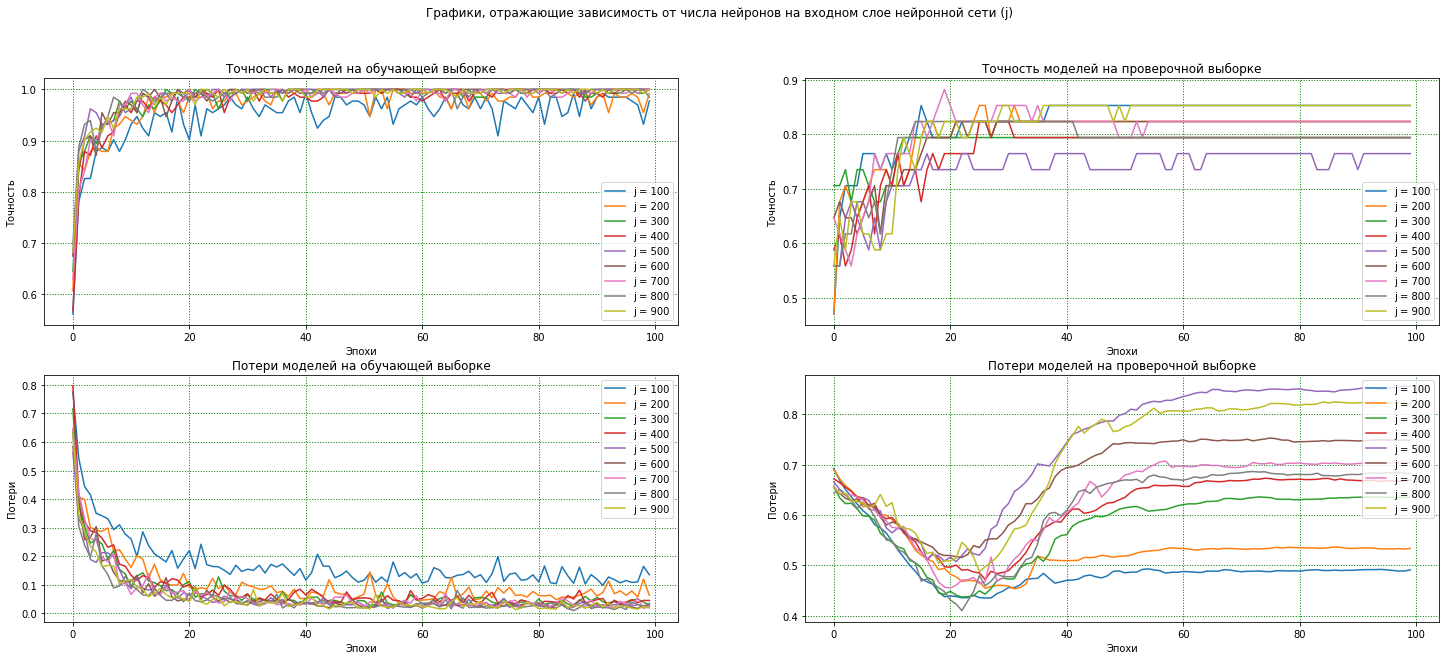

In [12]:
#@title Э4 [neyrons]. Попробуем посмотреть, как зависит точность от числа нейронов на входном слое.

testModels4 = []
labels = []

for j in range(100,1000,100):
  M = NN()
  M.createModel(firstLayerNeyrons=j)
  M.fitModel(x_train, y_train)
  M.scoreModel(x_test, y_test)
  labels.append('j = '+str(j))
  testModels4.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')

mainLabel = 'Графики, отражающие зависимость от числа нейронов на входном слое нейронной сети (j)'
runPlot(testModels4,labels,mainLabel)

In [13]:
#@title Э5 [earlystop]. Все вышепроведённые эксперименты показали, что после 20 эпохи почти во всех наблюдаемых случаях появляется эффект переобучения нейронки. Здесь мы включим параметр, останавливающий обучение при достижении определенного порога точности (или числа потерь). Настроив все параметры, исходя из определённых в предыдущих экспериментах результатов, будем добиваться 90% точности.

for j in range(100):
  M = NN()
  M.createModel()
  M.fitModel(x_train, y_train, earlyStop="1")
  M.scoreModel(x_test, y_test)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание выполнено.\n')
    break



2/2 [==============================] - 0s 2ms/step - loss: 0.2479 - accuracy: 0.9524

Точность тестовой выборки достигла 90% ! Задание выполнено.



## Pro. Вариант 1. Дополнительные эксперименты

2/2 [==============================] - 0s 3ms/step - loss: 0.2159 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.1977 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.2443 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.2256 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...



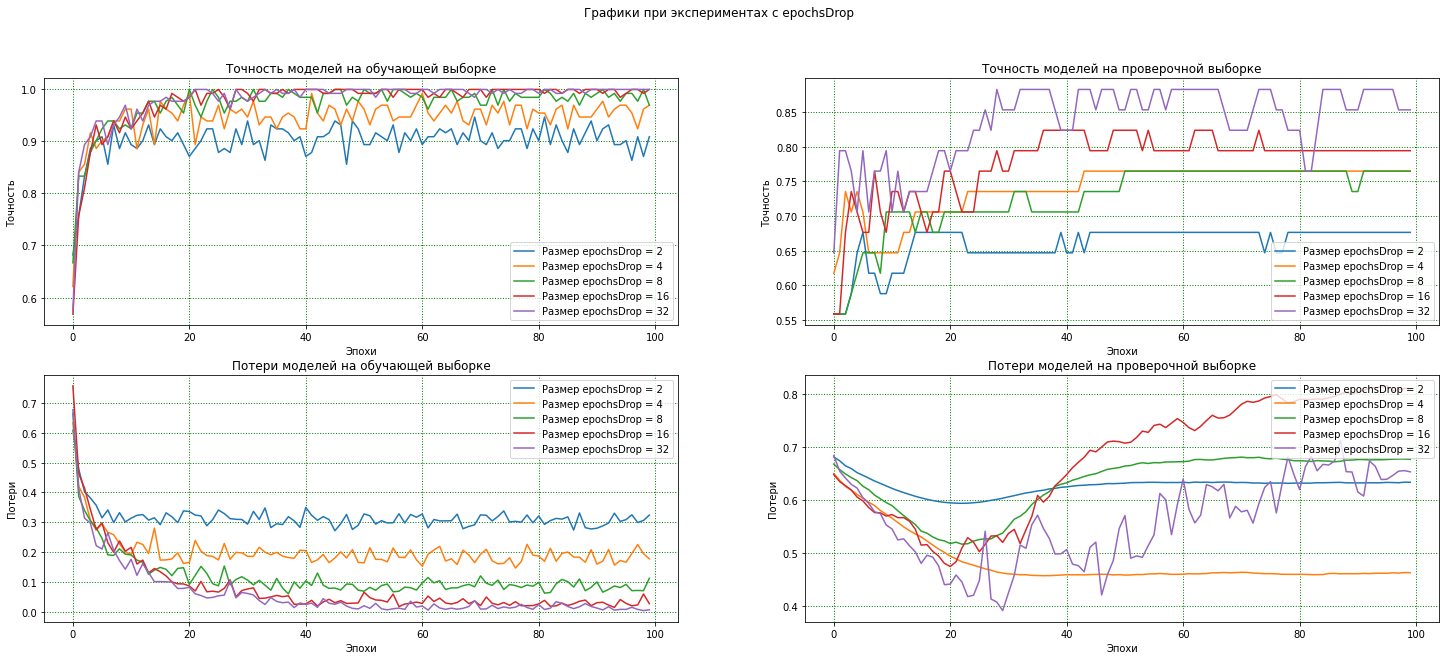

In [14]:
#@title Обучение модели с изменяемой скоростью обучения. Меняем параметр epochsDrop, определяющий, как часто изменяется скорость обучения (число эпох, после которого обучение меняется)

testModels_ = []
i = 0
labels = []

for epochsDrop in [2,4,8,16,32]:
  M = NN()
  M.createModel()
  M.fitModel(x_train, y_train, epochsDrop=epochsDrop)
  M.scoreModel(x_test, y_test)
  i += 1
  labels.append('Размер epochsDrop = '+str(epochsDrop))
  testModels_.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
    goodModels.append(M)

mainLabel = 'Графики при экспериментах с epochsDrop'
runPlot(testModels_,labels,mainLabel)

2/2 [==============================] - 0s 2ms/step - loss: 0.1867 - accuracy: 0.9286

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 2ms/step - loss: 0.1838 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.2778 - accuracy: 0.9048

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 3ms/step - loss: 0.1409 - accuracy: 0.9524

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...

2/2 [==============================] - 0s 2ms/step - loss: 0.3275 - accuracy: 0.9286

Точность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...



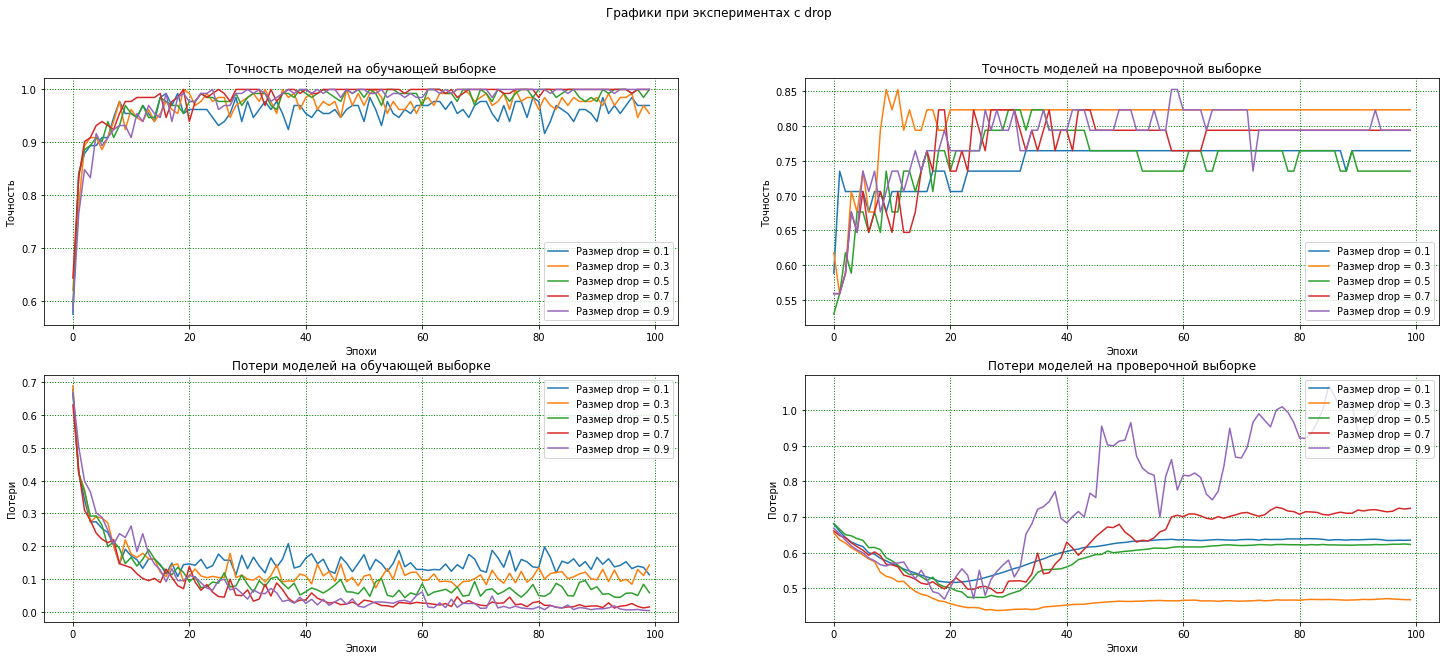

In [15]:
#@title Обучение модели с изменяемой скоростью обучения. Меняем параметр drop, величина, на которую скорость обучения изменяется каждый раз, когда она изменяется
testModels__ = []
i = 0
labels = []

for drop in range(1,10,2):
  M = NN()
  M.createModel()
  M.fitModel(x_train, y_train, drop=drop/10.0)
  M.scoreModel(x_test, y_test)
  i += 1
  labels.append('Размер drop = '+str(drop/10.0))
  testModels__.append(M)
  if M.score[1] >= 0.90:
    print('\nТочность тестовой выборки достигла 90% ! Задание уже выполнено. Но наши гипотезы ещё не иссякли...\n')
    goodModels.append(M)

mainLabel = 'Графики при экспериментах с drop'
runPlot(testModels__,labels,mainLabel)

# Pro. Вариант 2

По подготовленным на занятии данным создайте обучающую, тестовую и проверочную выборки. По сформированным данным необходимо обучить модель для предсказания цены машины.

Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен. Это можно сделать с помощью следующего метода:

> predict_inverse = y_scaler.inverse_transform(predict).flatten()

где predict - результат предсказания модели).

Затем рассчитайте ошибку на каждом примере тестовой выборки и суммарный процент ошибки.

Рекомендации:
1. В качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
2. Метрику для данной задачи можно не использовать.
3. Последний слой модели должен иметь 1 нейрон.

In [0]:
#@title Импорт библиотек

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
import math
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from google.colab import files
import seaborn as sns

In [0]:
#@title Инициализируем переменные для последующих экспериментов

class Car:
  '''
    Класс моделей нейронки
  '''
  
  def __init__(self):
    '''
      Инициализация последовательной модели нейронной сети
    '''
    self.history = defaultdict()   
    self.model = Sequential()

  def createModel(self,inputShape0 = 3208):
    '''
      Конструктор. Создается модель с заданными параметрами. Создаются элементы класса
    '''
    self.model.add(Dense(inputShape0, activation='relu', input_shape=(inputShape0, )))
    self.model.add(BatchNormalization())
    if inputShape0 < 1000:
      for i in range(5):
        self.model.add(Dropout(0.3))
        self.model.add(Dense(math.floor(inputShape0/4**i), activation='relu'))
        self.model.add(BatchNormalization())
    else:
      #self.model.add(Dropout(0.3))
      self.model.add(Dense(math.floor(inputShape0/10), activation='relu'))
      self.model.add(BatchNormalization())
      #self.model.add(Dropout(0.3))
      self.model.add(Dense(math.floor(inputShape0/100), activation='relu'))
      self.model.add(BatchNormalization())
    self.model.add(Dense(1, activation='sigmoid'))
    self.model.compile(loss='mse', optimizer='adam')


  def fitModel(self, 
               x, 
               y, 
               batchSize=512, 
               epochs=20):
    '''
      Обучение модели с определёнными параметрами
    '''
    self.lrate = LearningRateScheduler(self.step_decay)
    self.history = self.model.fit(x,y,batch_size=batchSize,
                                  epochs=epochs,validation_split=0.2,
                                  verbose=1,callbacks=[self.lrate])


  def scoreModel(self, x, y):
    self.score = self.model.evaluate(x, y)


  def step_decay(self,epoch):
    '''
      Функция для расчёта изменяемого шага обучения
    '''
    drop=0.1
    epochs_drop = 10
    initial_lrate = 0.1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

def create_dict(s):
  ret = {}
  for _id, name in enumerate(s):
    ret.update({name: _id})
  return ret

def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [4]:
#@title Загрузка сета машин с юлы
!rm cars_new*
files.upload()
!ls # Выводим содержимое корневой папки

cars_new.csv  pairplot.png  sample_data  sonar.csv


In [0]:
#@title Подготовка данных
# Прочитать данные в фрейм
df = pd.read_csv("cars_new.csv",sep=',')
# Создать словари текстовых названий
marks_dict = create_dict(set(df['mark']))
models_dict = create_dict(set(df['model']))
bodies_dict = create_dict(set(df['body']))
kpps_dict = create_dict(set(df['kpp']))
fuels_dict = create_dict(set(df['fuel']))
# Получить массив приведённых цен из столбца цен
prices = np.array(df['price'], dtype=np.float)
# Нормировать большие значения в базе 
years = scale(df['year'])
mileages = scale(df['mileage'])
volumes = scale(df['volume'])
powers = scale(df['power'])
#prices = scale(prices)
# Инициализировать тренировочный массив
x_set = []
y_set = []
# Читать полученные данные из фрейма
for _id, car in enumerate(np.array(df)):
  # Построчно добавлять цены в массив цен
  y_set.append(prices[_id])
  # Построчно создавать тензоры из строк с нормализованными и приведёнными данными
  x_set.append(to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]])
# Преобразовать данные в массив
x_set = np.array(x_set, dtype=np.float)
y_set = np.array(y_set, dtype=np.float)
# 
y_scaler = StandardScaler()
y_set_scaled = y_scaler.fit_transform(y_set.reshape(-1,1)).flatten()
x_train, x_test, y_train, y_test = train_test_split(x_set,y_set_scaled,test_size=0.2)

In [22]:
#@title Проверим, сколько на входе нужно иметь нейронов

x_train.shape[1]

(56095, 3208)

In [30]:
#@title Создание модели, компиляция, обучение, получение предсказания, вывод итогов.

model_ula = Car()
model_ula.createModel(x_train.shape[1])
model_ula.fitModel(x=x_train,y=y_train)
predict = model_ula.model.predict(x_test)
predict_inverse = y_scaler.inverse_transform(predict).flatten()

dfCars = pd.DataFrame()
dfCars['y_test'] = pd.Series(y_scaler.inverse_transform(y_test).flatten())
dfCars['predict_inverse'] = pd.Series(predict_inverse)
dfCars['error'] = pd.Series(np.abs(dfCars['predict_inverse'] - dfCars['y_test']))
dfCars['percent_error'] = pd.Series(dfCars['error'] / dfCars['y_test'] * 100)
dfCars.head(10)
print('Средняя ошибка предсказания цены: ',np.mean(dfCars['error']),
      '\nСредний процент ошибки предсказаний: ',np.mean(dfCars['percent_error']),
      '\nСуммарный процент ошибки предсказаний: ',np.sum(dfCars['percent_error']))

Epoch 1/20
99/99 [==============================] - 75s 756ms/step - loss: 0.8120 - val_loss: 0.9093 - lr: 1.0000
Epoch 2/20
99/99 [==============================] - 75s 755ms/step - loss: 0.7969 - val_loss: 0.8460 - lr: 1.0000
Epoch 3/20
99/99 [==============================] - 74s 752ms/step - loss: 0.8128 - val_loss: 0.8461 - lr: 0.1000
Epoch 4/20
99/99 [==============================] - 77s 776ms/step - loss: 0.8060 - val_loss: 0.8398 - lr: 0.1000
Epoch 5/20
99/99 [==============================] - 75s 753ms/step - loss: 0.7936 - val_loss: 0.8142 - lr: 0.1000
Epoch 6/20
99/99 [==============================] - 75s 756ms/step - loss: 0.7814 - val_loss: 0.8163 - lr: 0.0100
Epoch 7/20
99/99 [==============================] - 75s 753ms/step - loss: 0.7793 - val_loss: 0.8197 - lr: 0.0100
Epoch 8/20
99/99 [==============================] - 75s 753ms/step - loss: 0.7774 - val_loss: 0.8152 - lr: 0.0100
Epoch 9/20
99/99 [==============================] - 74s 752ms/step - loss: 0.7758 - val_

## Pro. Вариант 2. Дополнительные эксперименты

In [31]:
#@title Как видим, обучение показывает не очень хороший результат. Можно попробовать его улучшить. Для этого проанализируем данные.

df.head(20)

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0
5,hyundai,creta 1 поколение,985000,2016,34067,кроссовер,автомат,бензин,2.0,150.0
6,kia,ceed 2 поколение,589000,2013,98000,хетчбэк,автомат,бензин,1.6,129.0
7,toyota,corolla e140,500000,2008,141000,седан,автомат,бензин,1.6,124.0
8,mercedes-benz,c-класс 180 w204/s204/c204 [рестайлинг],1320000,2015,81112,седан,автомат,бензин,1.6,156.0
9,bmw,7 серия 735 e65/e66,270000,2001,300000,седан,автомат,бензин,3.6,272.0


In [14]:
#@title Проверим, сколько уникальных значений в каждом столбце.
for column in df.columns.values:
  print('Число уникальных записей в столбце',column,'равно',len(set(df[column])))

Число уникальных записей в столбце mark равно 21
Число уникальных записей в столбце model равно 3156
Число уникальных записей в столбце price равно 3562
Число уникальных записей в столбце year равно 52
Число уникальных записей в столбце mileage равно 15559
Число уникальных записей в столбце body равно 17
Число уникальных записей в столбце kpp равно 5
Число уникальных записей в столбце fuel равно 5
Число уникальных записей в столбце volume равно 65
Число уникальных записей в столбце power равно 337


In [53]:
#@title В поле model видим микс из слов, и можно посмотреть, насколько большой микс здесь зарыт.

print('В столбце model',len(set(df['model'].unique())),'уникальных значений, состоящих из нескольких слов')

В столбце model 3156 уникальных значений, состоящих из нескольких слов


In [6]:
#@title Так же можно обнаружить, что чаще всего запись в столбце model начинается с названия модели, а дальше идут детали, модификации. Можно отделить детали и модификации от остального. Добавим три столбца в фрейм: рестайлинг, поколение, серия, класс. 


#@markdown Примечание: если дополнительный эксперимент крашится, не хватает памяти в виртуальном опружении, то можно перезапустить Runtime, загрузить библиотеки и функции в первой секции, затем выполнить загрузку сета машин с юлы, а затем сразу запустить эту ячейку. При крахе указать параметр "FailOnRun" = "yes" ниже:

FailOnRun = "no"  #@param ['yes', 'no']

if FailOnRun == "yes":
  # Прочитать данные в фрейм
  df = pd.read_csv("cars_new.csv",sep=',')

df['generation'] = df['model'].str.extract(r'(\S+.поколение)')
df['restyle'] = df['model'].str.extract(r'(\S+\sрестайлинг\S+|\Sрестайлинг\S+)')
df['series'] = df['model'].str.extract(r'(\S+.серия)')
df['class'] = df['model'].str.extract(r'(\S+.класс)')
df['model_leftover'] = df['model'].str.replace(r'(\S+.серия)|(\S+\sрестайлинг\S+|\Sрестайлинг\S+)|(\S+.поколение)|(\S+.класс)','')

df.head(10)


,mark,model,price,year,mileage,body,kpp,fuel,volume,power,generation,restyle,series,class,model_leftover
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0,NaN,NaN,NaN,NaN,cerato
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0,1 поколение,[2-й рестайлинг],NaN,NaN,nexia
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0,3 поколение,[рестайлинг],NaN,NaN,jimny
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0,NaN,[рестайлинг],NaN,NaN,x1 18 e84
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0,1 поколение,NaN,NaN,NaN,lacetti
5,hyundai,creta 1 поколение,985000,2016,34067,кроссовер,автомат,бензин,2.0,150.0,1 поколение,NaN,NaN,NaN,creta
6,kia,ceed 2 поколение,589000,2013,98000,хетчбэк,автомат,бензин,1.6,129.0,2 поколение,NaN,NaN,NaN,ceed
7,toyota,corolla e140,500000,2008,141000,седан,автомат,бензин,1.6,124.0,NaN,NaN,NaN,NaN,corolla e140
8,mercedes-benz,c-класс 180 w204/s204/c204 [рестайлинг],1320000,2015,81112,седан,автомат,бензин,1.6,156.0,NaN,[рестайлинг],NaN,c-класс,180 w204/s204/c204
9,bmw,7 серия 735 e65/e66,270000,2001,300000,седан,автомат,бензин,3.6,272.0,NaN,NaN,7 серия,NaN,735 e65/e66


In [54]:
#@title Приглядимся повнимательнее к данным в столбце model_leftover. Выглядит так, что в нем осталось название модели. Посмотрим количество записей

print('В столбце model_leftover',len(set(df['model_leftover'].unique())),'уникальных значений, состоящих из нескольких слов')

В столбце model_leftover 2691 уникальных значений, состоящих из нескольких слов


In [65]:
df.model_leftover.values

array(['cerato', 'nexia  ', 'jimny  ', ..., 'cx-5 ', 'bb ',
       'trailblazer '], dtype=object)

In [7]:
#@title Всё ещё много. Проверим вот такую идею: если добавить в сет столбцы, полученные разбиением model_leftover на части (части строк, разделённые пробелом)

dfCols = df['model_leftover'].str.split(expand=True)
dfCols

,0,1,2,3,4
0,cerato,None,None,None,None
1,nexia,None,None,None,None
2,jimny,None,None,None,None
3,x1,18,e84,None,None
4,lacetti,None,None,None,None
...,...,...,...,...,...
70114,fabia,5j,None,None,None
70115,focus,None,None,None,None
70116,cx-5,None,None,None,None
70117,bb,None,None,None,None


In [92]:
#@title Получили 5 столбцов, в которых уникальных значений встречается:

for col in list(dfCols.columns.values):
  print('В столбце',col,'количество уникальных записей равно',len(set(dfCols[col])))

В столбце 0 количество уникальных записей равно 820
В столбце 1 количество уникальных записей равно 632
В столбце 2 количество уникальных записей равно 145
В столбце 3 количество уникальных записей равно 33
В столбце 4 количество уникальных записей равно 3


In [9]:
#@title Переформулируем наш сет данных. 

df['model_1'] = dfCols[0]
df['model_2'] = dfCols[1]
df['model_3'] = dfCols[2]
df['model_4'] = dfCols[3]
df['model_5'] = dfCols[4]
df



,mark,model,price,year,mileage,body,kpp,fuel,volume,power,generation,restyle,series,class,model_leftover,model_1,model_2,model_3,model_4,model_5
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0,NaN,NaN,NaN,NaN,cerato,cerato,None,None,None,None
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0,1 поколение,[2-й рестайлинг],NaN,NaN,nexia,nexia,None,None,None,None
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0,3 поколение,[рестайлинг],NaN,NaN,jimny,jimny,None,None,None,None
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0,NaN,[рестайлинг],NaN,NaN,x1 18 e84,x1,18,e84,None,None
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0,1 поколение,NaN,NaN,NaN,lacetti,lacetti,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70114,skoda,fabia 5j [рестайлинг],310000,2011,165000,хетчбэк,механика,бензин,1.2,70.0,NaN,[рестайлинг],NaN,NaN,fabia 5j,fabia,5j,None,None,None
70115,ford,focus 3 поколение,400000,2011,125000,хетчбэк,механика,бензин,1.6,105.0,3 поколение,NaN,NaN,NaN,focus,focus,None,None,None,None
70116,mazda,cx-5 1 поколение,1140000,2013,89981,кроссовер,автомат,бензин,2.0,150.0,1 поколение,NaN,NaN,NaN,cx-5,cx-5,None,None,None,None
70117,toyota,bb 2 поколение,550550,2006,183000,минивэн,автомат,бензин,1.3,92.0,2 поколение,NaN,NaN,NaN,bb,bb,None,None,None,None


In [121]:
#@title Проверим, сколько уникальных значений в каждом столбце.
for column in df.columns.values:
  print('Число уникальных записей в столбце',column,'равно',len(set(df[column])))

Число уникальных записей в столбце mark равно 21
Число уникальных записей в столбце model равно 3156
Число уникальных записей в столбце price равно 3562
Число уникальных записей в столбце year равно 52
Число уникальных записей в столбце mileage равно 15559
Число уникальных записей в столбце body равно 17
Число уникальных записей в столбце kpp равно 5
Число уникальных записей в столбце fuel равно 5
Число уникальных записей в столбце volume равно 65
Число уникальных записей в столбце power равно 337
Число уникальных записей в столбце generation равно 13
Число уникальных записей в столбце restyle равно 4
Число уникальных записей в столбце series равно 9
Число уникальных записей в столбце class равно 24
Число уникальных записей в столбце model_leftover равно 2691
Число уникальных записей в столбце model_1 равно 820
Число уникальных записей в столбце model_2 равно 632
Число уникальных записей в столбце model_3 равно 145
Число уникальных записей в столбце model_4 равно 33
Число уникальных за

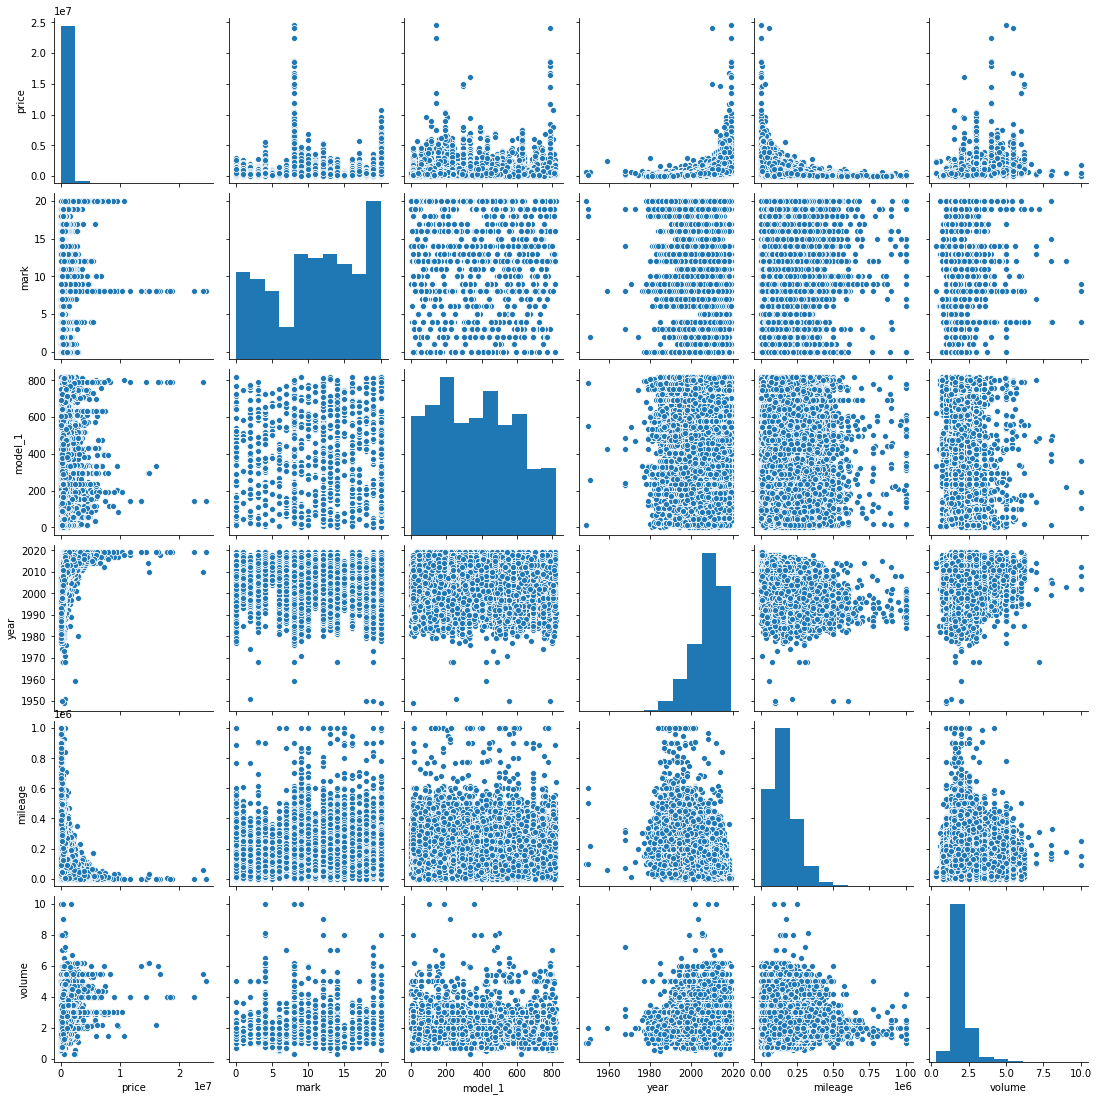

In [33]:
#@title Рискнем предположить, что столбцы 'mark', 'model_1', 'year', 'mileage', 'volume' несут больше полезной информации (поварьировал здесь с графиками парной зависимости и выделил эти столбцы)

colsFrame = pd.DataFrame()
dd = defaultdict()

#(mark, model), year, mileage, volume, power

def strInNum(strdict,string):
  return strdict[string]

for col in list(df.columns.values):
  if col not in ['year','mileage','volume','power','price']:
    dd[col] = dict(zip(set(df[col]),range(len(set(df[col])))))
    colsFrame[col] = df[col].apply(lambda x: strInNum(dd[col],x))
  else:
    colsFrame[col] = df[col]

sns_plot = sns.pairplot(colsFrame[['price','mark','model_1','year','mileage','volume']])

In [0]:
#@title Обработка данных. Здесь же поставлен эксперимент с отключением некоторых столбцов. Были оставлены столбцы, которые посчитал нужными исходя из предыдущего шага

df = df.fillna(0)
df.head()

# Создать словари текстовых названий. 
#   Нормировать большие численные значения. 
#   Получить массив приведенных цен
marks_dict = create_dict(set(df['mark']))            #0
models_dict = create_dict(set(df['model']))          #1
prices = np.array(df['price'], dtype=np.float)       #2
years = scale(df['year'])                            #3
mileages = scale(df['mileage'])                      #4
bodies_dict = create_dict(set(df['body']))           #5
kpps_dict = create_dict(set(df['kpp']))              #6
fuels_dict = create_dict(set(df['fuel']))            #7
volumes = scale(df['volume'])                        #8
powers = scale(df['power'])                          #9
gen_dict = create_dict(set(df['generation']))        #10
restyle_dict = create_dict(set(df['restyle']))       #11
series_dict = create_dict(set(df['series']))         #12
class_dict = create_dict(set(df['class']))           #13
models_leftover_dict = create_dict(set(df['model_leftover'])) #14
model1_dict = create_dict(set(df['model_1']))           #15
model2_dict = create_dict(set(df['model_2']))           #16
model3_dict = create_dict(set(df['model_3']))           #17
model4_dict = create_dict(set(df['model_4']))           #18
model5_dict = create_dict(set(df['model_5']))           #19

# 'mark', 'model_1', 'year', 'mileage', 'volume' 
# Инициализировать тренировочный массив
x_set2 = []
y_set2 = []
# Читать полученные данные из фрейма
for _id, car in enumerate(np.array(df)):
  # Построчно добавлять цены в массив цен
  y_set2.append(prices[_id])
  # Построчно создавать тензоры из строк с нормализованными и приведёнными данными
  # Здесь как раз можно "выключать" столбцы
  #print(car)
  x_set2.append([years[_id]] +
                #to_ohe(car[1], models_dict) +               
                [mileages[_id]] +
#                to_ohe(car[5], bodies_dict) +
#                to_ohe(car[6], kpps_dict) +
#                to_ohe(car[7], fuels_dict) +
                [volumes[_id]] +
#                [powers[_id]] +
#                to_ohe(car[10], gen_dict) +
#                to_ohe(car[11], restyle_dict) +
#                to_ohe(car[12], series_dict) +
#                to_ohe(car[13], class_dict) +
                #to_ohe(car[14], models_leftover_dict) +
                to_ohe(car[15], model1_dict) +
#                to_ohe(car[16], model2_dict) +
#                to_ohe(car[17], model3_dict) +
#                to_ohe(car[18], model4_dict) +
#                to_ohe(car[19], model5_dict)
                to_ohe(car[0], marks_dict)
                )

# Преобразовать данные в массив
x_set2 = np.array(x_set2, dtype=np.float)
y_set2 = np.array(y_set2, dtype=np.float)
# 
y_scaler2 = StandardScaler()
y_set_scaled2 = y_scaler2.fit_transform(y_set2.reshape(-1,1)).flatten()
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_set2,y_set_scaled2,test_size=0.2)
#df[['mark','price','year','mileage','body','kpp','fuel','volume','power','generation','restyle','series','class','model_1','model_2','model_3','model_4','model_5']]

In [35]:
#@title Проверим, сколько на входе нужно иметь нейронов

x_train2.shape[1]

844

In [36]:
#@title Повторное создание модели, получение описания модели

model_ula2 = Car()
model_ula2.createModel(inputShape0=x_train2.shape[1])
model_ula2.model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 844)               713180    
_________________________________________________________________
batch_normalization (BatchNo (None, 844)               3376      
_________________________________________________________________
dropout (Dropout)            (None, 844)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 844)               713180    
_________________________________________________________________
batch_normalization_1 (Batch (None, 844)               3376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 844)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 211)               1

In [37]:
#@title Компиляция, обучение, получение предсказания, вывод итогов.

model_ula2.fitModel(x=x_train2,y=y_train2)
predict2 = model_ula2.model.predict(x_test2)
predict_inverse2 = y_scaler2.inverse_transform(predict2).flatten()

dfCars2 = pd.DataFrame()
dfCars2['y_test'] = pd.Series(y_scaler2.inverse_transform(y_test2).flatten())
dfCars2['predict_inverse'] = pd.Series(predict_inverse2)
dfCars2['error'] = pd.Series(np.abs(dfCars2['predict_inverse'] - dfCars2['y_test']))
dfCars2['percent_error'] = pd.Series(dfCars2['error'] / dfCars2['y_test'] * 100)
dfCars2.head(10)
print('Средняя ошибка предсказания цены: ',np.mean(dfCars2['error']),
      '\nСредний процент ошибки предсказаний: ',np.mean(dfCars2['percent_error']),
      '\nСуммарный процент ошибки предсказаний: ',np.sum(dfCars2['percent_error']))

Epoch 1/20
88/88 [==============================] - 11s 122ms/step - loss: 0.7558 - val_loss: 0.6209 - lr: 0.1000
Epoch 2/20
88/88 [==============================] - 11s 121ms/step - loss: 0.7164 - val_loss: 0.5983 - lr: 0.1000
Epoch 3/20
88/88 [==============================] - 11s 120ms/step - loss: 0.7134 - val_loss: 0.5964 - lr: 0.1000
Epoch 4/20
88/88 [==============================] - 10s 119ms/step - loss: 0.7120 - val_loss: 0.5959 - lr: 0.1000
Epoch 5/20
88/88 [==============================] - 11s 120ms/step - loss: 0.7105 - val_loss: 0.5894 - lr: 0.1000
Epoch 6/20
88/88 [==============================] - 11s 119ms/step - loss: 0.7098 - val_loss: 0.5932 - lr: 0.1000
Epoch 7/20
88/88 [==============================] - 11s 120ms/step - loss: 0.7098 - val_loss: 0.5901 - lr: 0.1000
Epoch 8/20
88/88 [==============================] - 11s 119ms/step - loss: 0.7101 - val_loss: 0.5977 - lr: 0.1000
Epoch 9/20
88/88 [==============================] - 10s 119ms/step - loss: 0.7104 - val_

## Увы, лучшего результата достичь не удаётся. 
Товарищи учителя, подскажите, как я мог сделать результат лучше? )